In [1]:
import os
os.environ['PJRT_DEVICE'] = 'TPU'

import torch
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met


def xla_repeat_interleave(input, repeats, dim):
    met.clear_all()
    shape = list(input.shape)
    shape.insert(dim, repeats)

    expanded = input.unsqueeze(dim + 1)
    tiled = expanded.expand(*shape)
    result = tiled.reshape(-1, *shape[2:])
    print(met.metrics_report())
    return result

device = xm.xla_device()
# Input tensor
image_embeddings = torch.randn(torch.Size([1, 256, 64, 64]), device=device)
tokens = torch.randn(torch.Size([16, 8, 256]), device=device)

# Using xla_repeat_interleave function
result_xla = xla_repeat_interleave(image_embeddings, tokens.shape[0], dim=0)

# Using torch.repeat_interleave
result_builtin = torch.repeat_interleave(image_embeddings, tokens.shape[0], dim=0)

# Print the results
print("xla_repeat_interleave:")
print(result_xla)
print("torch.repeat_interleave:")
print(result_builtin)

# Check if the results are equal
print("Are the results equal?", torch.allclose(result_xla, result_builtin))

Counter: CreateXlaTensor
  Value: 3
Counter: xla::expand_symint
  Value: 1
Counter: xla::unsqueeze
  Value: 1
Counter: xla::view_symint
  Value: 1

xla_repeat_interleave:
tensor([[[[-0.6783, -0.3352,  1.1862,  ...,  0.5943,  0.6945,  0.2949],
          [ 0.8233,  0.0155, -1.0901,  ..., -0.9990,  0.8104,  0.3706],
          [-0.6425, -0.2450, -0.9264,  ...,  0.0396, -0.9698, -0.8212],
          ...,
          [ 0.1677, -0.2868, -0.5007,  ..., -0.1369, -1.0855, -0.3244],
          [ 2.0562, -1.1668,  0.6644,  ...,  0.9703, -0.6673,  1.2617],
          [-0.3927,  0.7532, -0.0586,  ...,  0.4447,  1.3878, -0.0295]],

         [[ 0.7528, -0.3819, -1.0636,  ..., -0.1932,  0.9681, -0.4283],
          [ 0.2421,  0.0424, -0.4103,  ...,  0.7230,  0.5019,  1.5766],
          [-0.0991,  2.1333, -0.6871,  ...,  1.1626, -0.3252, -0.1060],
          ...,
          [-0.9665,  0.1913, -0.6528,  ..., -1.7360,  0.4690, -1.3952],
          [ 0.6700, -1.9343,  0.2071,  ..., -0.2868,  0.8358, -0.0427],
     

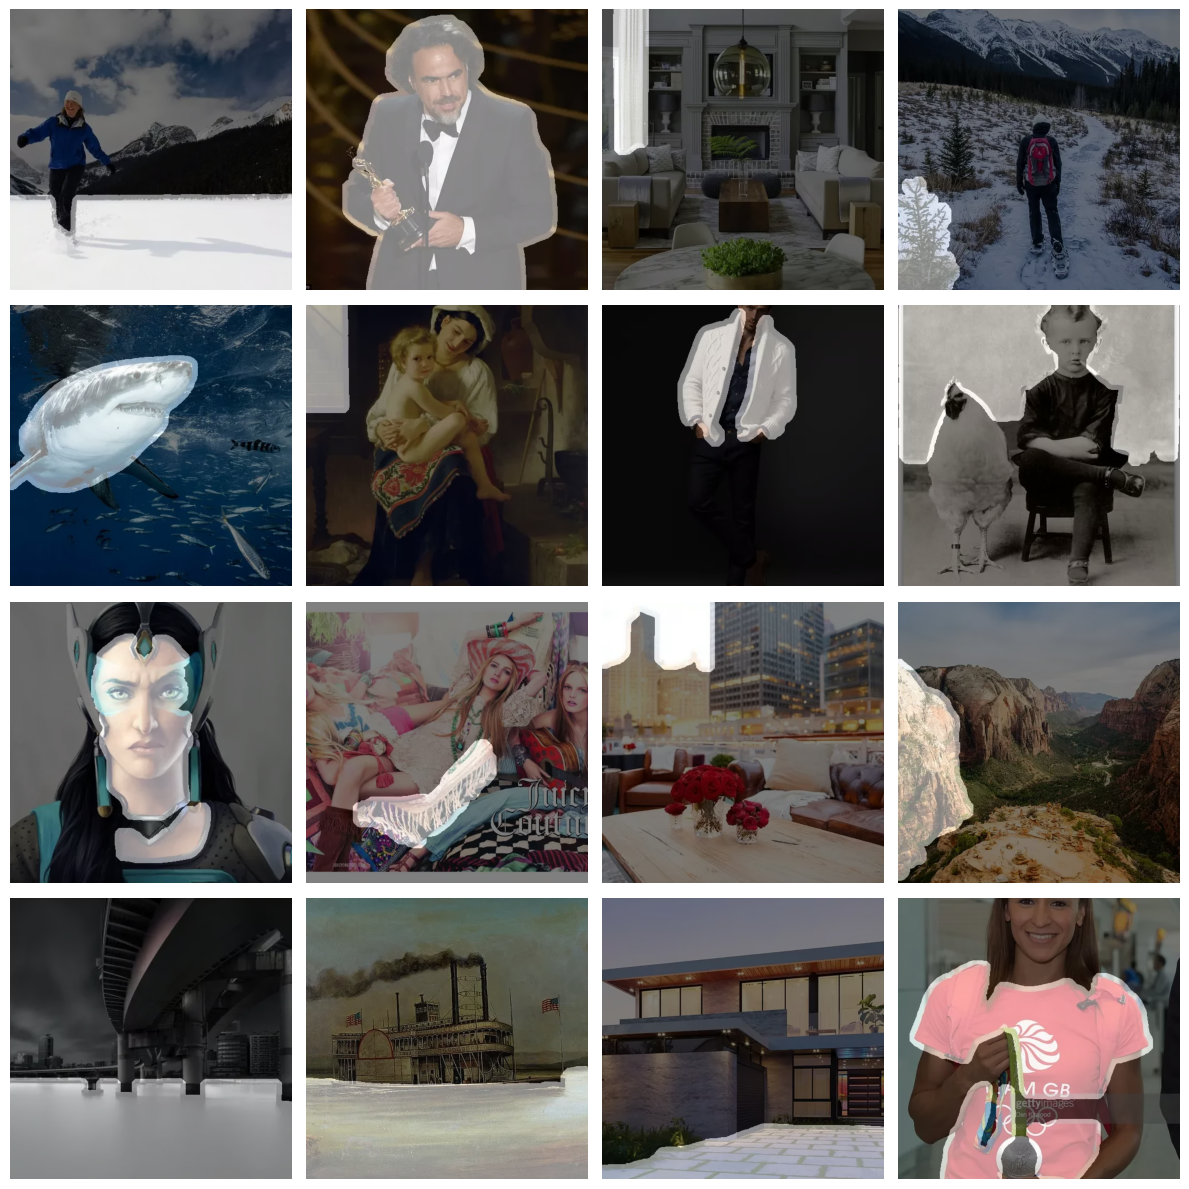

In [5]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Directory paths
image_dir = './data/zd_testimgs/'
mask_dir = './data/out_masks/'

# Get a list of all image files in the directory
image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)

# Randomly sample 16 images
sampled_images = random.sample(image_files, 16)

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))

# Iterate over the sampled images
for i, image_file in enumerate(sampled_images):
    # Get the corresponding mask file
    mask_file = image_file
    
    # Load the image and mask using matplotlib
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, mask_file)
    image = mpimg.imread(image_path)
    mask = mpimg.imread(mask_path)
    
    # Get the current subplot
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    # Overlay the mask on the image
    ax.imshow(image)
    ax.imshow(mask, alpha=0.5, cmap='gray')
    
    # Remove ticks and labels
    ax.axis('off')

plt.tight_layout()
plt.show()

In [1]:
import os

# os.environ['LD_LIBRARY_PATH'] = os.environ.get('LD_LIBRARY_PATH', '') + ':/home/drhead/miniconda3/envs/sam_hq_xla/lib:/usr/local/cuda/targets/x86_64-linux/lib'
os.environ['PT_XLA_DEBUG'] = '1' 
os.environ['PT_XLA_DEBUG_FILE'] = './xla_debug.txt'
os.environ['PJRT_DEVICE'] = 'TPU'

# Nonzero op lowering is unstable but seems to work for some ops
# os.environ['XLA_EXPERIMENTAL'] = 'nonzero'

# Will cast torch.float and torch.double to BF16
os.environ['XLA_USE_BF16'] = '1'

os.environ['XLA_EMIT_STEPLOG'] = '1'
# Will cast torch.float to BF16 and torch.double to float32
# os.environ['XLA_DOWNCAST_BF16'] = '1'
os.environ['XLA_IR_DEBUG'] = '1'
os.environ['XLA_HLO_DEBUG'] = '1'
os.environ['MASTER_PORT'] = '29500'

import numpy as np
import torch
print("PyTorch version:", torch.__version__)
import torch_xla.core.xla_model as xm

import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.optim as optim
import torch.distributed as dist
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_backend
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.experimental.pjrt_backend
import torch_xla.experimental.pjrt as pjrt
import matplotlib.pyplot as plt
import cv2
import time

import torch_xla.debug.profiler as xp
import torch_xla.utils.utils as xu
import multiprocessing


PyTorch version: 2.1.0


In [21]:
random_tensor = torch.randn((128,128), device=xm.xla_device())
boolean_tensor = random_tensor > 0

nonzero_count = boolean_tensor.sum(dim=0).to(torch.int32)

print(nonzero_count.shape)
print(nonzero_count.ndim)
print(nonzero_count)
nonzero_count = boolean_tensor.count_nonzero()

print(met.short_metrics_report())
met.clear_all()

torch.Size([128])
1
tensor([68, 59, 62, 63, 68, 62, 62, 54, 72, 65, 65, 55, 66, 70, 65, 67, 65, 65,
        63, 78, 71, 67, 65, 70, 73, 63, 70, 70, 72, 71, 57, 74, 72, 55, 63, 54,
        61, 64, 62, 58, 70, 67, 65, 75, 65, 56, 62, 74, 62, 60, 59, 63, 61, 67,
        74, 71, 64, 70, 62, 64, 59, 70, 58, 60, 54, 60, 68, 66, 66, 63, 66, 64,
        66, 69, 68, 74, 72, 61, 72, 53, 74, 64, 69, 61, 65, 59, 67, 63, 63, 61,
        61, 61, 61, 73, 69, 69, 58, 63, 63, 64, 68, 61, 67, 67, 67, 80, 62, 63,
        70, 66, 67, 54, 66, 78, 70, 64, 63, 71, 57, 67, 69, 70, 69, 64, 63, 62,
        66, 64], device='xla:0', dtype=torch.int32)
Metric: CompileTime
  TotalSamples: 1
  Accumulator: 141ms515.942us
  Percentiles: 1%=141ms515.942us; 5%=141ms515.942us; 10%=141ms515.942us; 20%=141ms515.942us; 50%=141ms515.942us; 80%=141ms515.942us; 90%=141ms515.942us; 95%=141ms515.942us; 99%=141ms515.942us
Metric: ExecuteTime
  TotalSamples: 1
  Accumulator: 002ms156.581us
  Percentiles: 1%=002ms156.581us; 5%=002

In [3]:
import torch_xla.debug.metrics as met
print(met.short_metrics_report())
met.clear_all()

Counter: CachedCompile
  Value: 1
Metric: CompileTime
  TotalSamples: 2
  Accumulator: 148ms386.609us
  ValueRate: 02s775ms750.247us / second
  Rate: 23.9206 / second
  Percentiles: 1%=074ms192.071us; 5%=074ms192.071us; 10%=074ms192.071us; 20%=074ms192.071us; 50%=074ms194.538us; 80%=074ms194.538us; 90%=074ms194.538us; 95%=074ms194.538us; 99%=074ms194.538us
Metric: ExecuteTime
  TotalSamples: 3
  Accumulator: 004ms431.715us
  ValueRate: 054ms578.398us / second
  Rate: 36.2693 / second
  Percentiles: 1%=001ms153.732us; 5%=001ms153.732us; 10%=001ms153.732us; 20%=001ms153.732us; 50%=002ms519.499us; 80%=002ms758.484us; 90%=002ms758.484us; 95%=002ms758.484us; 99%=002ms758.484us
Metric: TransferToServerTime
  TotalSamples: 2
  Accumulator: 223.102us
  ValueRate: 211ms014.858us / second
  Rate: 1891.64 / second
  Percentiles: 1%=060.269us; 5%=060.269us; 10%=060.269us; 20%=060.269us; 50%=162.833us; 80%=162.833us; 90%=162.833us; 95%=162.833us; 99%=162.833us
Metric: TransferFromServerTime
  Total